# 1 File Input

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score

import warnings
warnings.filterwarnings('ignore')

# Load the CSV file into a df
file_path = "mhealth.csv"
df = pd.read_csv(file_path)

df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [25]:
# Make 'subject' first column, 'Activity' last column
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

df.head()

,subject,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity
0,subject1,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0
1,subject1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0
2,subject1,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0
3,subject1,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0
4,subject1,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0


# 2 Exploratory Data Analysis

In [ ]:
# To be continued

In [26]:
# Calculating the number of missing values in each column of the sampled dataset
missing_values = df.isnull().sum()

missing_values

subject     0
alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
dtype: int64

# 3 Data Preprocessing

#### 3.1 Split to train and test datasets

In [27]:
# For the train DataFrame (66:33 split)
train_subjects = ['subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6']
train_df_normalized = df[df['subject'].isin(train_subjects)]

# For the test DataFrame
test_subjects = ['subject7', 'subject8', 'subject9']
test_df_normalized = df[df['subject'].isin(test_subjects)]

#### 3.2 Normalize values

In [28]:
from sklearn.preprocessing import StandardScaler

# Identifying numerical columns (excluding 'subject' and 'Activity')
numerical_columns = train_df_normalized.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('Activity')

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df_normalized[numerical_columns] = scaler.fit_transform(train_df_normalized[numerical_columns])
test_df_normalized[numerical_columns] = scaler.transform(test_df_normalized[numerical_columns])

# Checking the first few rows of the normalized training data
train_df_normalized.head()

,subject,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity
0,subject1,0.199165,-0.017148,0.309088,0.376638,-0.589487,-0.962208,-1.041599,0.160844,-0.668889,-0.207277,-0.981516,-0.404945,0
1,subject1,0.250775,0.027716,0.318869,0.338268,-0.584307,-0.955039,-1.036926,0.205402,-0.710325,-0.207277,-0.981516,-0.404945,0
2,subject1,0.256122,0.013594,0.318361,0.338268,-0.584307,-0.955039,-1.011477,0.212750,-0.646688,-0.207277,-0.981516,-0.404945,0
3,subject1,0.198274,0.046237,0.294272,0.338268,-0.584307,-0.955039,-1.037010,0.206005,-0.623518,-0.222250,-0.977888,-0.420281,0
4,subject1,0.258337,0.056032,0.323858,0.338268,-0.584307,-0.955039,-1.052217,0.235400,-0.613480,-0.222250,-0.977888,-0.420281,0


#### 3.3 Generate sequences and pad sequences

In [7]:
sensor_columns = ['alx','aly','alz','glx','gly','glz','arx','ary','arz','grx','gry','grz']

def create_sequences(df, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(df) - sequence_length + 1, sequence_length):
        sequence = df[i:i + sequence_length]
        # Assuming 'Activity' is the target variable and is the same for the entire sequence
        label = sequence['Activity'].iloc[0]  
        sequences.append(sequence[sensor_columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df_normalized, sequence_length=100)
X_test, y_test = create_sequences(test_df_normalized, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7488, 100, 12), (7488,), (2511, 100, 12), (2511,))

In [44]:
from keras.preprocessing.sequence import pad_sequences

# Padding sequences
max_length = max(len(s) for s in X_train)
# We can also go with max_length
padded_sequences = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float')

padded_sequences.shape

(7488, 100, 12)

In [45]:
# Padding sequences for the test set
padded_sequences_test = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float')

padded_sequences_test.shape

(2511, 100, 12)

#### 3.4 Data balancing

In [46]:
from collections import Counter

# Class distribution
class_distribution = Counter(y_train)
print(class_distribution)

Counter({0: 5409, 1: 186, 10: 186, 2: 185, 3: 185, 4: 185, 11: 185, 5: 185, 9: 184, 7: 180, 8: 180, 6: 177, 12: 61})


##### 3.4.1 Downsampling Activity = 0

In [82]:
from sklearn.utils import resample

counts = [class_distribution.get(i, 0) for i in range(max(class_distribution.keys()) + 1)]
target_count = int(np.median(counts[1:]))
# target_count = int(np.median(counts[1:]) * 1.5) # Using 1.5 times median count of non-zero activities

# Separate sequences for "Activity 0"
act_0_seq = padded_sequences[y_train == 0]
other_act_seq = padded_sequences[y_train != 0]

# Also separate the labels
act_0_labels = y_train[y_train == 0]
other_act_labels = y_train[y_train != 0]

# Perform undersamping for "Activity 0"
act_0_seq_bal = resample(act_0_seq, replace=False, n_samples=int(target_count), random_state=42)

act_0_labels_bal = np.zeros(int(target_count))

# Combine the undersampled data with the other activities
padded_sequences_bal = np.concatenate((act_0_seq_bal, other_act_seq))
y_train_bal = np.concatenate((act_0_labels_bal, other_act_labels))

# Check the new distribution
unique_balanced, counts_balanced = np.unique(y_train_bal, return_counts=True)
new_class_distribution = dict(zip(unique_balanced, counts_balanced))
print(new_class_distribution)

# Validate the shapes
print(padded_sequences_bal.shape, y_train_bal.shape)

{0.0: 185, 1.0: 186, 2.0: 185, 3.0: 185, 4.0: 185, 5.0: 185, 6.0: 177, 7.0: 180, 8.0: 180, 9.0: 184, 10.0: 186, 11.0: 185, 12.0: 61}
(2264, 100, 12) (2264,)


##### 3.4.2 Oversampling Activity = 12

In [84]:
# Separate sequences for "Activity 12"
act_12_seq = padded_sequences_bal[y_train_bal == 12]
act_12_labels = y_train_bal[y_train_bal == 12]

# Target count for oversampling is the median
oversample_target_count = int(np.median(counts[1:]))

# If the current count is less than the target count, perform oversampling
if len(act_12_seq) < oversample_target_count:
    act_12_seq_oversampled = resample(act_12_seq, replace=True, n_samples=oversample_target_count - len(act_12_seq), random_state=42)
    act_12_labels_oversampled = np.full(oversample_target_count - len(act_12_seq), 12)

    # Add the oversampled data back to the training set
    padded_sequences_bal = np.concatenate((padded_sequences_bal, act_12_seq_oversampled))
    y_train_bal = np.concatenate((y_train_bal, act_12_labels_oversampled))

# Check the new distribution
unique_balanced, counts_balanced = np.unique(y_train_bal, return_counts=True)
new_class_distribution = dict(zip(unique_balanced, counts_balanced))
print(new_class_distribution)

# Validate the shapes
print(padded_sequences_bal.shape, y_train_bal.shape)

{0.0: 185, 1.0: 186, 2.0: 185, 3.0: 185, 4.0: 185, 5.0: 185, 6.0: 177, 7.0: 180, 8.0: 180, 9.0: 184, 10.0: 186, 11.0: 185, 12.0: 185}
(2388, 100, 12) (2388,)


# 4 Long Short-Term Memory (LSTM) RNN

In [91]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
input_size = padded_sequences_bal.shape[2]
hidden_size = 256  # Number of hidden units in RNN
num_classes = len(df['Activity'].unique())
landa = 0.001  # Regularization term (lambda)

epochs = 100
learning_rate = 0.001
batch_size = 128

# Hyperparameters
# learning_rate = [0.001, 0.01, 0.1]
# batch_size = [128, 256, 512]
# epochs = [5, 50, 100]
# Create model for below to use in GridSearchCV

# Data preparation
train_dataset = TensorDataset(t.tensor(padded_sequences_bal, dtype=t.float32), t.tensor(y_train_bal, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(padded_sequences_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.2)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.2)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
# optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

#best_train_loss = float('inf')
#patience = 5
#trigger_times = 0

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out, Y)
        
        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    #train_loss = sum(per_epoch_loss_list) / len(per_epoch_loss_list)
    
    #train_loss_list.append(train_loss)

    #if train_loss < best_train_loss:
        #best_train_loss = train_loss
        #trigger_times = 0
    #else:
        #trigger_times += 1

    #if trigger_times >= patience:
        #print(f'Early stopping at {epoch}')
        #break

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/100 ---> Train Accuracy: 34.63149078726968%, Validation Accuracy: 6.05336519315014%
Epoch 1/100 ---> Train Accuracy: 50.71189279731993%, Validation Accuracy: 7.128634010354441%
Epoch 2/100 ---> Train Accuracy: 62.3534338358459%, Validation Accuracy: 10.51373954599761%
Epoch 3/100 ---> Train Accuracy: 70.39363484087102%, Validation Accuracy: 12.504978096375947%
Epoch 4/100 ---> Train Accuracy: 70.30988274706867%, Validation Accuracy: 14.13779370768618%
Epoch 5/100 ---> Train Accuracy: 76.6750418760469%, Validation Accuracy: 16.92552767821585%
Epoch 6/100 ---> Train Accuracy: 73.07370184254606%, Validation Accuracy: 16.56710473914775%
Epoch 7/100 ---> Train Accuracy: 79.94137353433835%, Validation Accuracy: 12.266029470330546%
Epoch 8/100 ---> Train Accuracy: 81.15577889447236%, Validation Accuracy: 16.766228594185584%
Epoch 9/100 ---> Train Accuracy: 80.40201005025126%, Validation Accuracy: 18.040621266427717%
Epoch 10/100 ---> Train Accuracy: 82.03517587939699%, Validation Accu

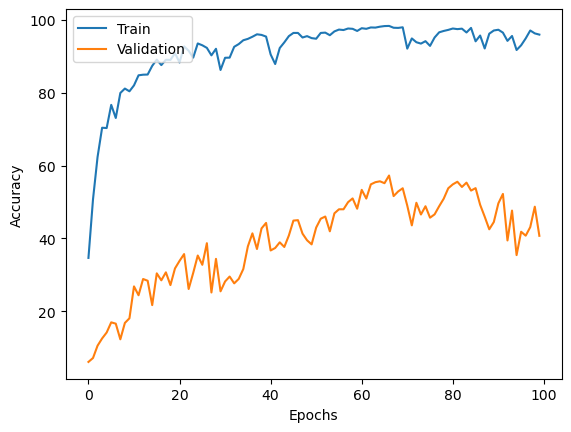

In [92]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

#### 4.1 Optuna Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):

    return evaluation_score

study = optuna.create_study()
study.optimize(objective, n_trials =)

In [ ]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler